# Religious Migration Analysis 1990-2020
#### Author: Kristofer O'Garro
#### Date: 11/21/2024
#### Data Source: Pew Research Center (https://www.pewresearch.org/dataset/dataset-religious-composition-of-the-worlds-migrants-1990-2020/)

This analysis explores global religious migration patterns from 1990-2020, examining how migration flows have influenced religious demographics across different geographical scales.

Dataset Structure:
- 26712 rows
- 9 columns
- Hierarchical data (Country -> Regional -> Global levels)
- Time period: 1990-2020 (5-year intervals)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [4]:
migration = pd.read_csv('data/Incoming_and_Outgoing_Migrant_Counts.csv', thousands=',')
migration.head(5)

,Direction,Year,Country,Religion,Count,Percent,Region,level,countrycode
0,Incoming,1990,Global Total,All,"152,970,000",100.0,Global,3,9999
1,Incoming,1990,Global Total,Buddhist,"4,590,000",3.0,Global,3,9999
2,Incoming,1990,Global Total,Christian,"72,710,000",47.5,Global,3,9999
3,Incoming,1990,Global Total,Hindu,"9,130,000",6.0,Global,3,9999
4,Incoming,1990,Global Total,Jew,"2,340,000",1.5,Global,3,9999


## Function definitions

In [6]:
def explore_data_quality(df):
    """
    Perform initial data quality checks.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe to analyze
        
    Returns:
    --------
    dict
        Dictionary containing data quality metrics
    """
    quality_report = {
        'missing_values': df.isnull().sum(),
        'unique_values': {col: df[col].nunique() for col in df.columns},
        'data_types': df.dtypes
    }
    return quality_report

def format_numbers(ax):
    """
    Format y-axis numbers to use comma separators instead of scientific notation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object to format
        
    Returns
    -------
    None
        Modifies the axis object in place

    Example
    -------
    >>> fig, ax = plt.subplots()
    >>> plot_data(ax)
    >>> format_numbers(ax)
    """
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

## Cleaning the data

In [8]:
explore_data_quality(migration)

{'missing_values': Direction      0
 Year           0
 Country        0
 Religion       0
 Count          0
 Percent        0
 Region         0
 level          0
 countrycode    0
 dtype: int64,
 'unique_values': {'Direction': 2,
  'Year': 7,
  'Country': 239,
  'Religion': 8,
  'Count': 834,
  'Percent': 955,
  'Region': 7,
  'level': 3,
  'countrycode': 239},
 'data_types': Direction       object
 Year             int64
 Country         object
 Religion        object
 Count           object
 Percent        float64
 Region          object
 level            int64
 countrycode      int64
 dtype: object}

In [9]:
#Changing the following column type to 'category' for memory optimization: Direction, Religion, Region, Level 
migration = migration.astype({
    'Direction': 'category',
    'Religion': 'category',
    'Region': 'category',
    'level': 'category',
})

#Standardized column names to lowercase
migration.columns = migration.columns.str.lower()

#Replacing values of '< 10,000' with 5,000 for numerical calculations. The number 5000 was chosen as a midpoint since we don't have the actual numbers
migration['count'] = migration['count'].replace('< 10,000', '5000')

#Remove commas and convert 'count' to numbers
migration['count'] = migration['count'].str.replace(',', '')
migration['count'] = pd.to_numeric(migration['count'])

## Global Migration

### Data Prep for Global Analysis

In [12]:
# Global Migration Trends 1990 to 2020
global_level_df = migration[(migration['level'] == 3) & # filter for global level data
                          (migration['religion'] != 'All') & # remove 'All' value. 'All' rows total every religion
                          (migration['direction'] == 'Incoming')].copy() #Filter for only 'Incoming' to avoid doubling the actual number of migrants
global_level_df['religion'] = global_level_df['religion'].cat.remove_categories(['All']) # Removing 'All' from category so it doesn't show up in charts
order = global_level_df.groupby('religion', observed=True)['count'].mean().sort_values(ascending=False).index # Storing sort order in variable for barplot

# Migration Growth Rates by Religious Group 1990-2020
global_growth_df = global_level_df.pivot_table(index='religion', columns='year', values='count') #Pivot the dataframe with years as column, migration count as values and religion as index
global_growth_df['growthrate'] = (global_growth_df[2020] - global_growth_df[1990]) / global_growth_df[1990] * 100 #Add growth rate column
global_growth_df['abs_diff'] = global_growth_df[2020] - global_growth_df[1990] # Add an absolute difference column

# Global Migration Growth Rates by Religious Group Before and After 2005
growth_periods_df = global_growth_df.copy()
growth_periods_df['post_2005'] = round((growth_periods_df[2020] - growth_periods_df[2005]) / growth_periods_df[2005] * 100)
growth_periods_df['pre_2005'] = round((growth_periods_df[2005] - growth_periods_df[1990]) / growth_periods_df[1990] * 100)
growth_periods_df.reset_index(inplace=True)
growth_periods_df = pd.melt(growth_periods_df, 
                           id_vars=['religion'], 
                           value_vars=['pre_2005', 'post_2005'], 
                           var_name='period', 
                           value_name='growth rate')

#### Global migration patterns show steady growth from 1990 to 2020, with a notable acceleration after 2005. During this period, both the volume and composition of religious migration underwent significant changes...

**Key Findings**:
- Global migration increased 83.4% from 1990 to 2020.
- Christians and Muslims consistently represent the largest migration groups.
- Despite smaller total numbers, Buddhist migration showed the highest growth rate of 137%.
- Muslims had the largest migration growth rate post-2005.
- Buddhists were the only group to see a decline in migration growth post-2005.
- Jewish migration remains generally low, indicating some level of stability.

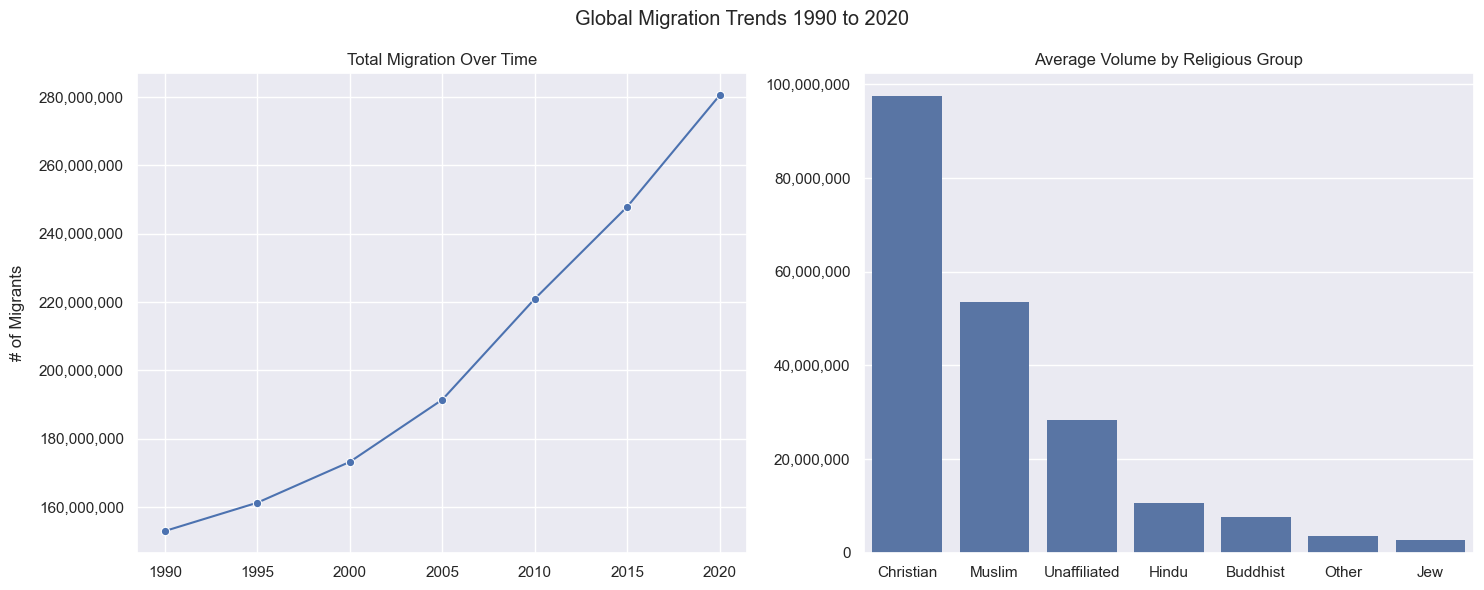

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=global_level_df, 
             x='year', y='count', 
             errorbar=None, marker='o', 
             estimator=sum, ax=ax1)
format_numbers(ax1)
ax1.set_ylabel('# of Migrants', labelpad=10)
ax1.set_xlabel('')
ax1.set_title('Total Migration Over Time')

sns.barplot(data = global_level_df, 
            x='religion', y='count', 
            errorbar=None, order=order, 
            linewidth=0, ax=ax2)
format_numbers(ax2)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Average Volume by Religious Group')

plt.suptitle('Global Migration Trends 1990 to 2020')
plt.tight_layout()

Global migration has consistently increased with an inflection point after 2005. Christians have the highest amounts of migration on average, followed by Muslims and the religiously unaffiliated.

### Global Growth Rates
How have growth rates changed?

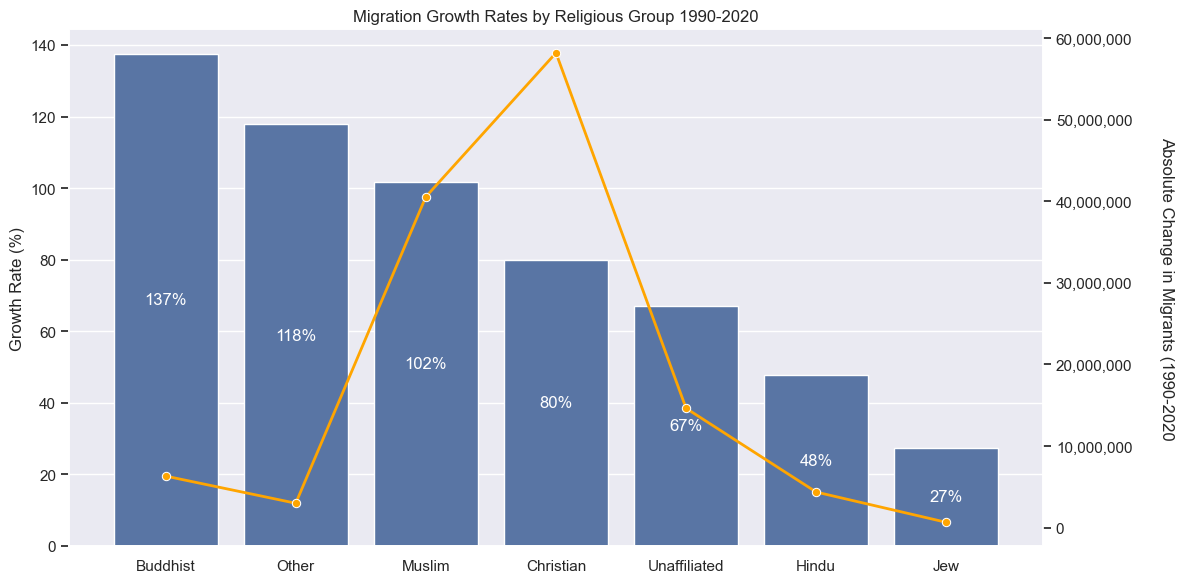

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(data=global_growth_df, 
            x='religion', y='growthrate',
           order=global_growth_df.sort_values('growthrate', ascending=False).index,
           ax=ax1)

ax1.set_xlabel('')
ax1.set_ylabel('Growth Rate (%)')
ax1.bar_label(ax1.containers[0], label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

ax2 = ax1.twinx()
sns.lineplot(data=global_growth_df,
             x='religion', y='abs_diff',
             ax=ax2, color='orange',
             linewidth=2, marker='o')

format_numbers(ax2)
ax2.set_ylabel('Absolute Change in Migrants (1990-2020', labelpad=30, rotation=270)
ax2.grid(alpha=0)


plt.title('Migration Growth Rates by Religious Group 1990-2020')
plt.tight_layout()

Despite having smaller overall numbers of change, Buddhists represent the highest growth percentage of all religious groups. Christians, having the highest migration numbers, fall to the middle of the pack with around 80% growth, still a relatively high numbers.

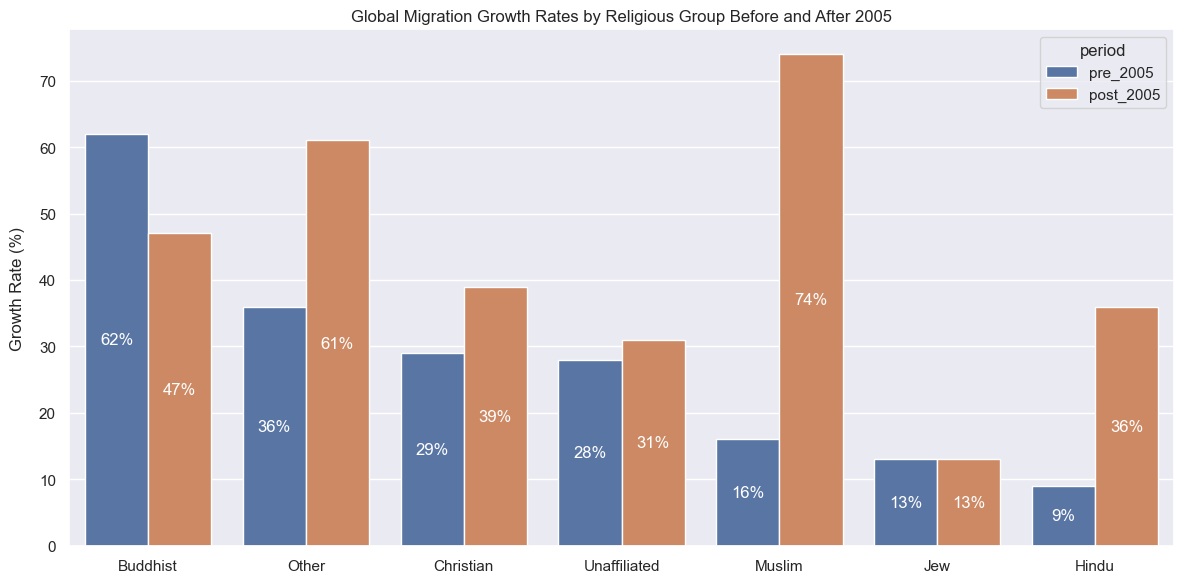

In [19]:
plt.figure(figsize=(12, 6))

order = growth_periods_df[growth_periods_df['period'] == 'pre_2005'].sort_values('growth rate', ascending=False)['religion']

ax = sns.barplot(growth_periods_df, 
                 x='religion', y='growth rate', 
                 hue='period', order=order)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

plt.xlabel('')
plt.ylabel('Growth Rate (%)', labelpad=10)
plt.title('Global Migration Growth Rates by Religious Group Before and After 2005')
plt.tight_layout()

Muslims represent the largest growth post-2005. Interestingly, most groups showed post 2005 increases except for Buddhists, who's growth slightly declined.

#### These global patterns, however, mask significant regional variations in both the volume and religious composition of migration flows...

# Regional Breakdown

### Data Prep for Regional Analysis

In [24]:
region_level_df = migration[migration['level'] == 2].copy()
region_level_df['region'] = region_level_df['region'].cat.remove_categories(['Global'])

#Overall Net Migration by Region 1990-2020
pivoted_region_level = region_level_df.pivot_table(values='count', columns='direction', index='region').astype('int') #pivoting region_level_df to focus on incoming vs outgoing by region
net_diff = pivoted_region_level['Incoming'] - pivoted_region_level['Outgoing']

# Regional Net Migration Trends Show Growing Disparities 1990-2020
pivoted_region_year_df = region_level_df.pivot_table(values='count', columns='direction', index=['region', 'year'])
pivoted_region_year_df['net_migration'] = pivoted_region_year_df['Incoming'] - pivoted_region_year_df['Outgoing']
net_migration_df = pivoted_region_year_df.reset_index(['region', 'year'])

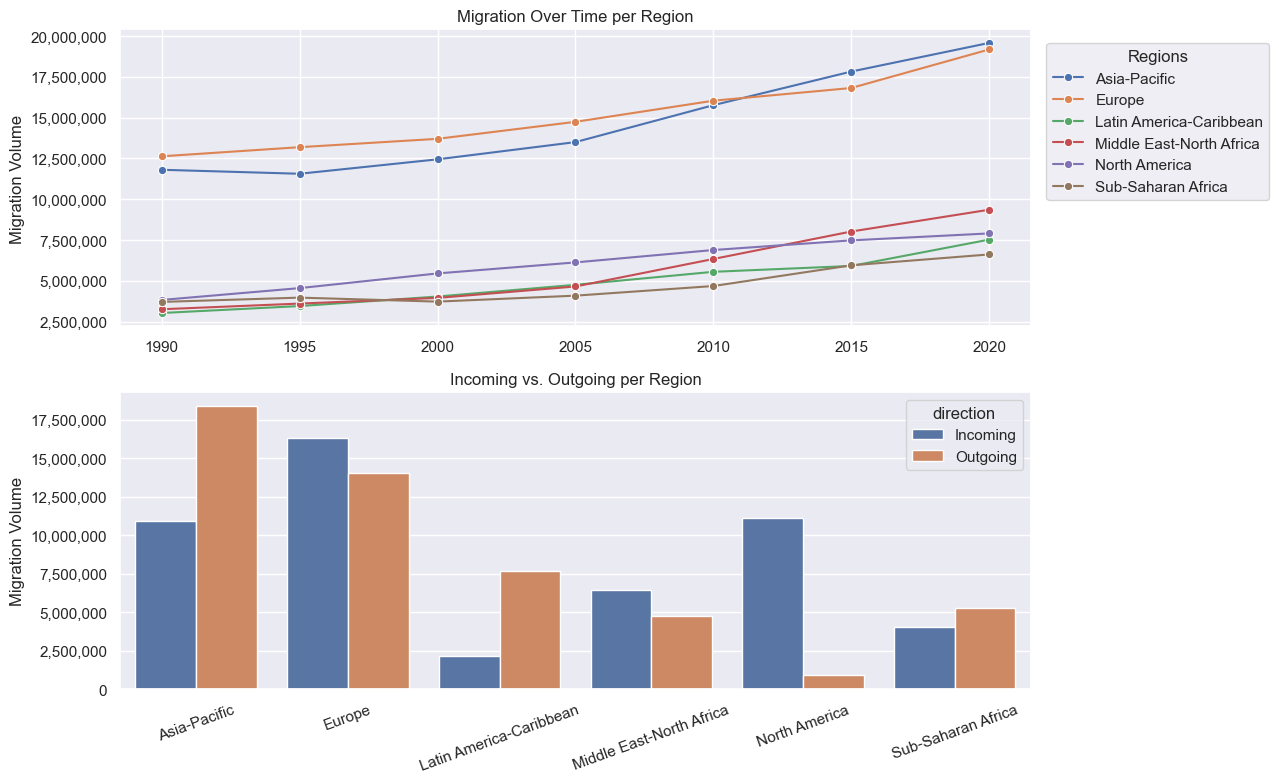

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8))  # Make figure wider
plt.subplots_adjust(right=0.85)  # Leave room for legend

sns.lineplot(data=region_level_df, x='year', y='count', hue='region', errorbar=None, marker='o', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Migration Volume')
ax1.set_title('Migration Over Time per Region')
format_numbers(ax1)
ax1.legend(title="Regions",loc='center', bbox_to_anchor=(1.14, 0.69))

sns.barplot(data=region_level_df, x='region', y='count', errorbar=None, hue='direction', ax=ax2)

ax2.set_xlabel('')
ax2.set_ylabel('Migration Volume')
ax2.set_title('Incoming vs. Outgoing per Region')
format_numbers(ax2)
plt.xticks(rotation=20)

plt.tight_layout()

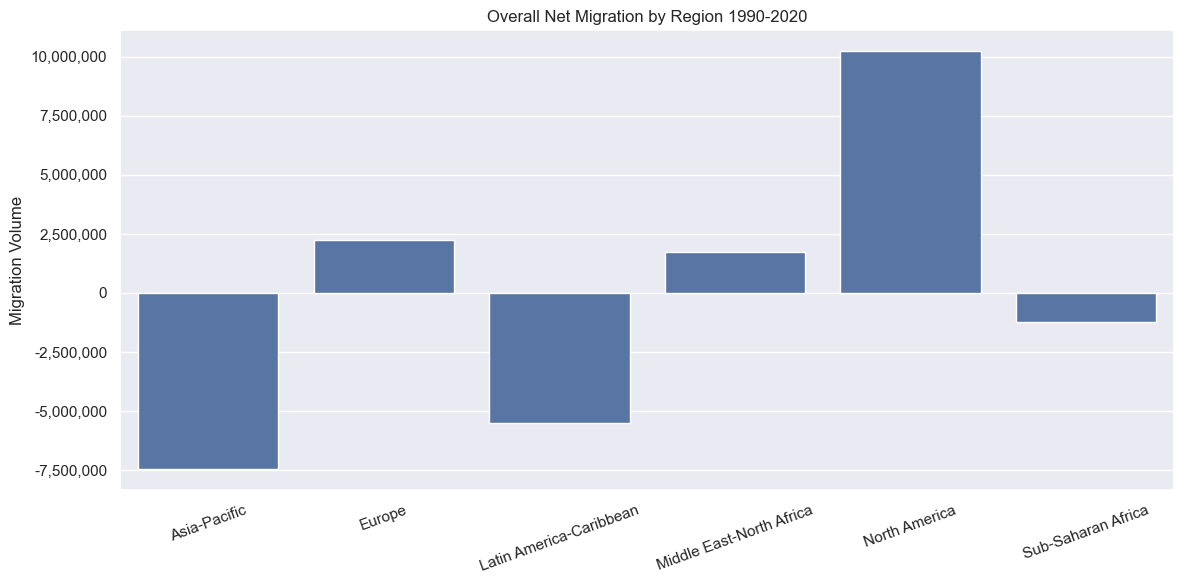

In [26]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(net_diff)
format_numbers(ax)

plt.title('Overall Net Migration by Region 1990-2020')
plt.ylabel('Migration Volume')
plt.xlabel('')
plt.xticks(rotation=20)
plt.tight_layout()

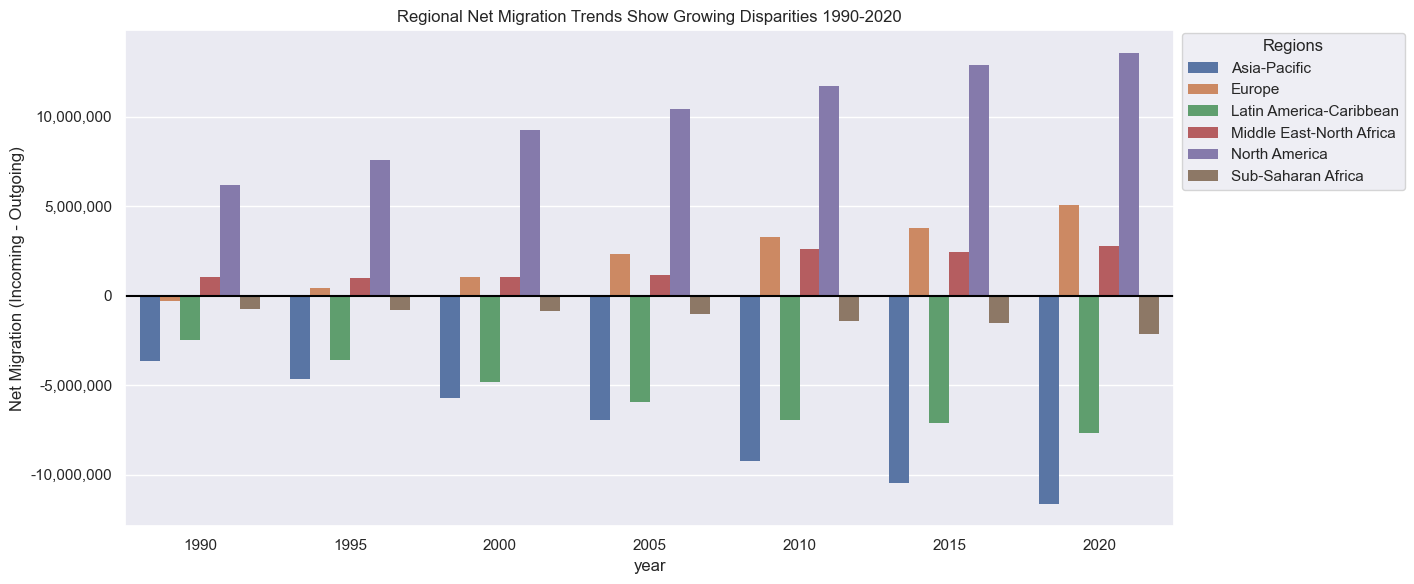

In [27]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(net_migration_df, 
                 x='year', 
                 y='net_migration', 
                 hue='region', linewidth=0)
format_numbers(ax)
plt.ylabel('Net Migration (Incoming - Outgoing)')
plt.title('Regional Net Migration Trends Show Growing Disparities 1990-2020')

plt.axhline(y=0, color='black', linestyle='-')

plt.tight_layout()
plt.legend(title="Regions", bbox_to_anchor=(1, 1.01));

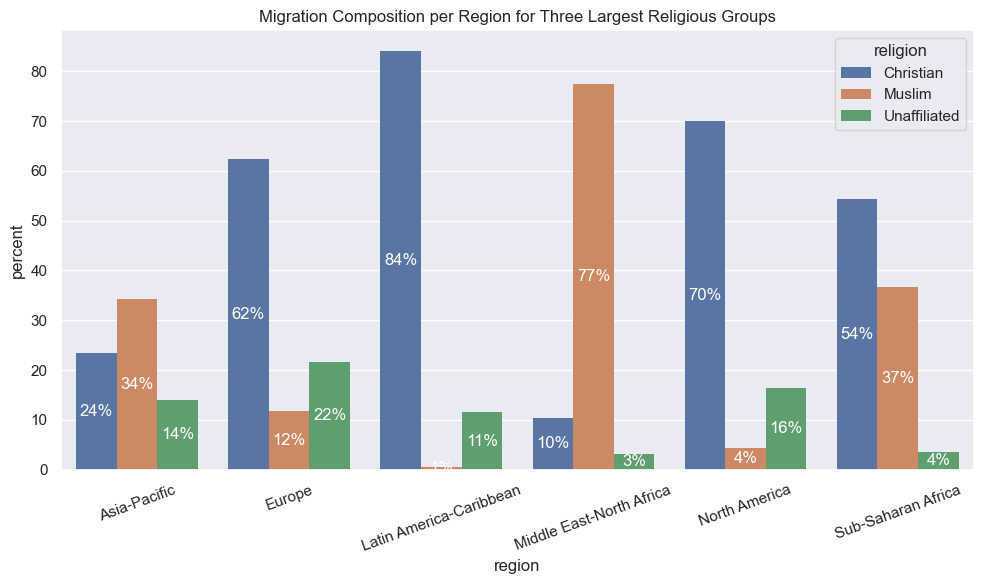

In [28]:
top3_religions = ['Christian', 'Muslim', 'Unaffiliated'] #storing top 3 religions by average migration volume
pivoted_region_religion_df = (region_level_df[region_level_df['religion'].isin(top3_religions)]
                            .pivot_table(index=['region', 'religion'], 
                                       values='percent')
                            .reset_index())

pivoted_region_religion_df['religion'] = pivoted_region_religion_df['religion'].cat.remove_categories(['All', 'Buddhist', 'Hindu', 'Jew', 'Other'])

# ---------------plots below
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=pivoted_region_religion_df, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')
    
format_numbers(ax)
plt.xticks(rotation=20)
plt.title('Migration Composition per Region for Three Largest Religious Groups')
plt.tight_layout()

In [29]:
pivoted_region_religion_df

,region,religion,percent
0,Asia-Pacific,Christian,23.507143
1,Asia-Pacific,Muslim,34.307143
2,Asia-Pacific,Unaffiliated,13.992857
3,Europe,Christian,62.428571
4,Europe,Muslim,11.850000
5,Europe,Unaffiliated,21.678571
6,Latin America-Caribbean,Christian,83.992857
7,Latin America-Caribbean,Muslim,0.585714
8,Latin America-Caribbean,Unaffiliated,11.485714
9,Middle East-North Africa,Christian,10.321429


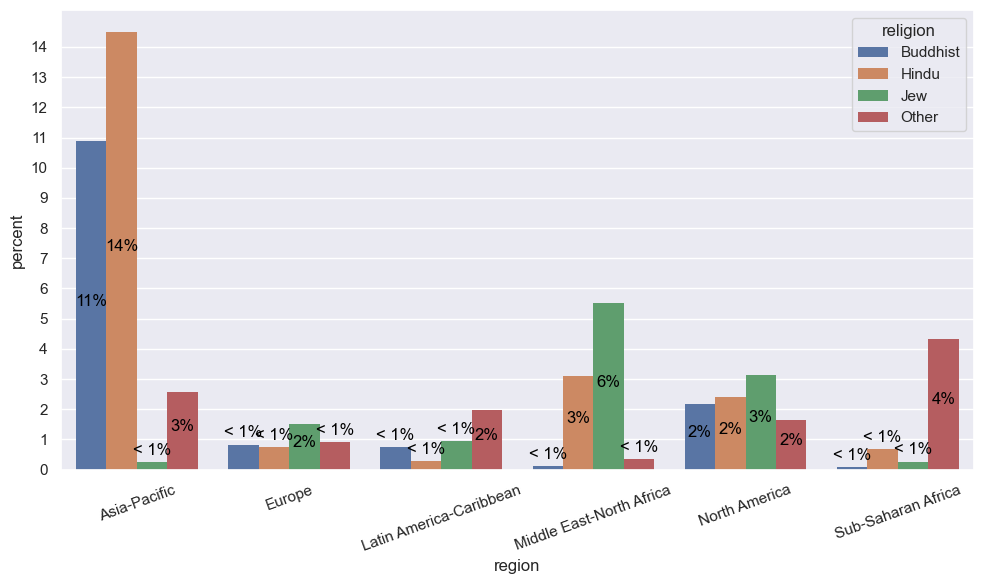

In [30]:
desired_religions = ['Buddhist', 'Hindu', 'Jew', 'Other']
pivoted_region_religion_df = (region_level_df[
    (region_level_df['religion'].isin(desired_religions))
    ]
    .pivot_table(index=['region', 'religion'], 
                values='percent')
    .reset_index())
pivoted_region_religion_df['religion'] = pivoted_region_religion_df['religion'].cat.remove_categories(['All', 'Christian', 'Muslim', 'Unaffiliated'])
# ---------------plots below
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=pivoted_region_religion_df, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0)


for container in ax.containers:
    # Handle values >= 1%
    ax.bar_label(container, label_type='center', color='black',
                fmt=lambda x: f'{x:.0f}%' if x >= 1 else '', 
                padding=3)
    # Handle values < 1%
    ax.bar_label(container, label_type='edge', color='black',
                fmt=lambda x: '< 1%' if x < 1 else '', 
                padding=3)
    
format_numbers(ax)
plt.xticks(rotation=20)
plt.yticks(range(0, 15, 1))  # ticks every 5%
plt.tight_layout()